# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# magic word for producing visualizations in notebook
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

In [3]:
sklearn.__version__

'1.0.1'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [4]:
# Load in the general demographics data.
azdias = pd.read_csv('/content/drive/MyDrive/Identify-Customer-Segments-Unsupervised/Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('/content/drive/MyDrive/Identify-Customer-Segments-Unsupervised/AZDIAS_Feature_Summary.csv', sep=';')

In [5]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [6]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(f'Shape of demographics dataset is {azdias.shape}')
azdias.head()

Shape of demographics dataset is (891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,...,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,...,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,...,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,...,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,...,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [7]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

In [8]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,...,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,817722.000000,...,891221.000000,891221.000000,817722.000000,817722.000000,817722.000000,872873.000000,306609.000000,783619.000000,817722.000000,798073.000000,794213.000000,798073.000000,817252.000000,798073.000000,798073.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,797481.000000,797481.000000,797481.000000,798066.000000,770025.000000,757897.000000,886367.000000,770025.000000,785421.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,1101.178533,7.350304,0.196612,1.792102,14.622637,4.453621,3.599574,2.185966,4.791151,2.432575,1.026827,8.154346,3.419630,3.945860,4.272729,4.240609,4.001597,4.023709,4.359086,4.481405,4.025014,3.910139,4.763223,4.667550,4.445007,4.256076,3.661784,1.266967,0.008423,...,1.197852,3.362438,10.864126,1.727637,0.004162,4.207243,3.410640,3.933406,7.908791,8.287263,0.040647,2.798641,3.018452,1993.277011,4.052836,1.494277,1.265584,0.624525,0.305927,1.389552,3.158580,4.153043,3.939172,4.549491,3.738306,2.592991,2.963540,2.698691,4.257967,619.701439,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,976.583551,3.525723,0.397437,1.269062,12.616883,3.855639,3.926486,1.756537,3.425305,1.474315,0.586634,4.844532,1.417741,1.946564,1.915885,2.007373,1.857540,2.077746,2.022829,1.807552,1.903816,1.580306,1.830789,1.795712,1.852412,1.770137,1.707637,1.287435,0.091392,...,0.952532,1.352704,7.639683,1.155849,0.068855,1.624057,1.628844,1.964701,1.923137,15.628087,0.324028,2.656713,1.550312,3.332739,1.949539,1.403961,1.245178,1.013443,0.638725,1.779483,1.329537,2.183710,1.718996,2.028919,0.923193,1.119052,1.428882,1.521524,2.030385,340.034318,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,..

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
# Identify missing or unknown data values and convert them to NaNs.

# Convert missing_or_unknown column values from str to list
feat_info_int = feat_info.copy() # deep copy needed when changing new df does not change the old one
for i in range(len(feat_info)):
    missing_or_unknown_str = feat_info.loc[i,'missing_or_unknown'][1:-1].split(',')
    missing_or_unknown_list = [int(i) if i.isnumeric() or i.lstrip('-').isnumeric() else i for i in missing_or_unknown_str ]
    feat_info_int.loc[i,'missing_or_unknown'] = missing_or_unknown_list



In [10]:
feat_info_int.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [11]:
# Convert Missing Value Codes in azdias dataset to numpy NaNs 
azdias_copy = azdias.copy()
for i in range(len(feat_info_int)):
    miss_list = feat_info_int.loc[i, 'missing_or_unknown']
    attr_name = feat_info_int.loc[i, 'attribute']
    for miss_val in miss_list:
        azdias_copy.loc[azdias[attr_name] == miss_val , attr_name] = np.nan
        


In [12]:
azdias_copy.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,...,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,NaN,10.0,0.0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2.0,6.0,7.0,5.0,1.0,5.0,3.0,3.0,4.0,7.0,6.0,6.0,5.0,3.0,NaN,NaN,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,1996.0,10.0,0.0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,3.0,1.0,...,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,1979.0,10.0,1.0,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,2.0,0.0,...,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,1957.0,1.0,0.0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,1.0,0.0,...,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,1963.0,5.0,0.0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,2.0,0.0,...,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,NaN,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [13]:
# Number of naturally missing data  for each attribute in original azdias dataset
azdias.isnull().sum(axis = 0) #.tolist()

AGER_TYP                     0
ALTERSKATEGORIE_GROB         0
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
                         ...  
PLZ8_HHZ                116515
PLZ8_GBZ                116515
ARBEIT                   97216
ORTSGR_KLS9              97216
RELAT_AB                 97216
Length: 85, dtype: int64

In [14]:
# Number of total missing or unknown data  for each attribute in azdias dataset after convertin missing value codes to NaNs
azdias_copy.isnull().sum(axis = 0) #.tolist()

AGER_TYP                685843
ALTERSKATEGORIE_GROB      2881
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
                         ...  
PLZ8_HHZ                116515
PLZ8_GBZ                116515
ARBEIT                   97375
ORTSGR_KLS9              97274
RELAT_AB                 97375
Length: 85, dtype: int64

In [15]:
azdias_copy.isnull().sum(axis = 0).sum()

8373929

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [16]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# Number of total missing or unknown data  for each attribute in azdias dataset after convertin missing value codes to NaNs
missing_num = azdias_copy.isnull().sum(axis = 0) #, columns=['attribute', 'number of missing data'])#.tolist()
missing_df = pd.DataFrame(missing_num, columns=['number of missing data'])
missing_df


,number of missing data
AGER_TYP,685843
ALTERSKATEGORIE_GROB,2881
ANREDE_KZ,0
CJT_GESAMTTYP,4854
FINANZ_MINIMALIST,0
...,...
PLZ8_HHZ,116515
PLZ8_GBZ,116515
ARBEIT,97375
ORTSGR_KLS9,97274


In [17]:
# Investigate patterns in the amount of missing data in each column.

# Find percentage of data missing in each column
missing_data_percentage = missing_num / azdias_copy.shape[0] * 100
missing_data_percentage.sort_values(ascending=False, inplace=True)
missing_data_percentage

TITEL_KZ         99.757636
AGER_TYP         76.955435
KK_KUNDENTYP     65.596749
KBA05_BAUMAX     53.468668
GEBURTSJAHR      44.020282
                   ...    
SEMIO_DOM         0.000000
SEMIO_KAEM        0.000000
SEMIO_PFLICHT     0.000000
SEMIO_TRADV       0.000000
ZABEOTYP          0.000000
Length: 85, dtype: float64

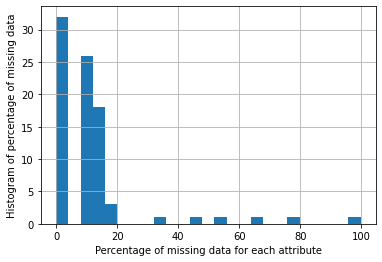

In [18]:
# hist plot the percentage of data missing in each column
plt.hist(missing_data_percentage,  bins=25)  # density=False would make counts
plt.ylabel('Histogram of percentage of missing data')
plt.xlabel('Percentage of missing data for each attribute');
plt.grid(True)
plt.show()

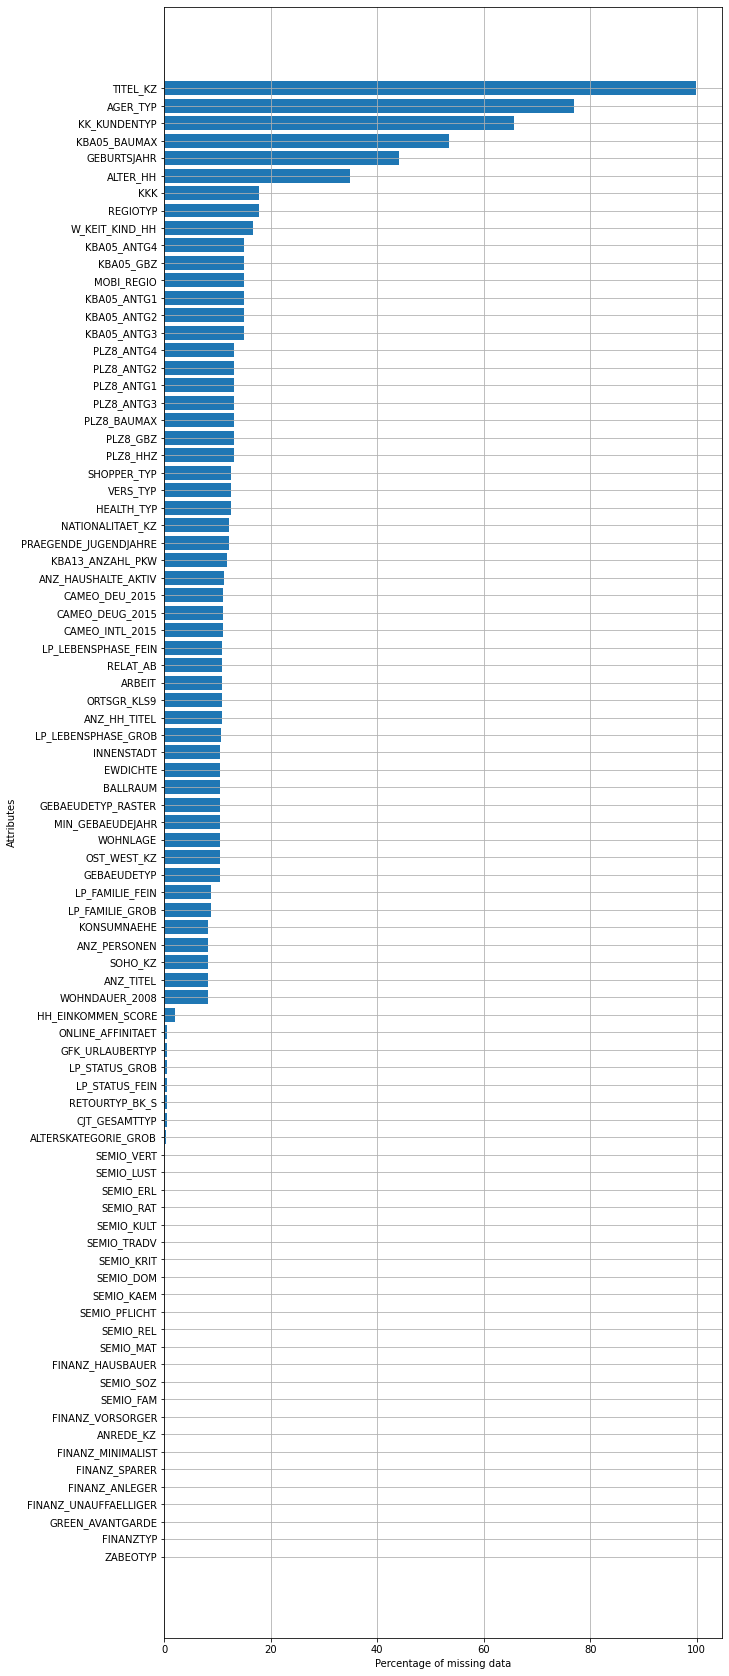

In [19]:
# barh plot of percentage of data missing in each column
fig = plt.figure(figsize=(10, 30))
missing_data_percentage.sort_values(inplace=True)
plt.barh(missing_data_percentage.index, missing_data_percentage)
plt.ylabel('Attributes')
plt.xlabel('Percentage of missing data')
plt.grid(True)
plt.show()

In [20]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# Find number of columns that have more than 25% missing data
outlier_column_count = len(missing_data_percentage.loc[missing_data_percentage>25])
outlier_column_name = missing_data_percentage.loc[missing_data_percentage>25].index.tolist()
print(f"Number of columns that have more than 25% missing data is {outlier_column_count}")
print(f"Name of columns that have more than 25% missing data are {outlier_column_name}")

Number of columns that have more than 25% missing data is 6
Name of columns that have more than 25% missing data are ['ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP', 'TITEL_KZ']


In [21]:
# Remove outliers columns ['ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP', 'TITEL_KZ'] 
# that have more than 25% missing data

azdias_outlier_col_removed = azdias_copy.drop(columns=['ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP', 'TITEL_KZ'] )
azdias_outlier_col_removed.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,10.0,0.0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2.0,6.0,7.0,5.0,1.0,5.0,3.0,3.0,4.0,7.0,6.0,6.0,5.0,3.0,NaN,NaN,NaN,3.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,10.0,0.0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,3.0,1.0,2.0,5.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,10.0,1.0,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,2.0,0.0,1.0,5.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,1.0,0.0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,1.0,0.0,1.0,3.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,5.0,0.0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,2.0,0.0,2.0,4.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [22]:
azdias_outlier_col_removed.shape

(891221, 79)

In [23]:
missing_num_no_outlier_col = azdias_outlier_col_removed.isnull().sum()
missing_num_no_outlier_col

ALTERSKATEGORIE_GROB      2881
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
FINANZ_SPARER                0
                         ...  
PLZ8_HHZ                116515
PLZ8_GBZ                116515
ARBEIT                   97375
ORTSGR_KLS9              97274
RELAT_AB                 97375
Length: 79, dtype: int64

In [24]:
# number of missing data after removing outlier columns
azdias_outlier_col_removed.isnull().sum().sum()

5035304

In [25]:
missing_p_no_outlier_col = missing_data_percentage.loc[missing_data_percentage<25]
missing_p_no_outlier_col.sort_values(ascending=False, inplace=True)
missing_p_no_outlier_col

KKK               17.735668
REGIOTYP          17.735668
W_KEIT_KIND_HH    16.605084
KBA05_GBZ         14.959701
MOBI_REGIO        14.959701
                    ...    
SEMIO_KULT         0.000000
SEMIO_ERL          0.000000
SEMIO_LUST         0.000000
SEMIO_VERT         0.000000
ZABEOTYP           0.000000
Length: 79, dtype: float64

#### Discussion 1.1.2: Assess Missing Data in Each Column

In this section, azdias demographics dataset was investigated. This dataset had 8373929 missing data in total. The columns with more than 25% missing values namely `'ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP', 'TITEL_KZ'` were removed from dataset to reduce the negative impact of missing data on the results. The number of missing data after removing outlier columns are 5035304 in total.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [26]:
# How much data is missing in each row of the dataset?
missing_num_row = azdias_outlier_col_removed.isnull().sum(axis=1)
missing_row_df = pd.DataFrame(missing_num_row, columns=['number of missing data'])
missing_row_df.sort_values(by='number of missing data', ascending=False)

,number of missing data
732775,49
643174,49
472919,48
345274,47
299868,47
...,...
349047,0
349048,0
349049,0
349050,0


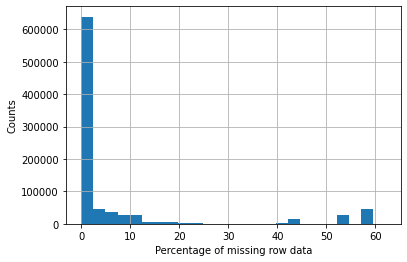

In [27]:
missing_row_percent = missing_num_row / azdias_outlier_col_removed.shape[1] * 100
plt.hist(missing_row_percent, bins=25)
plt.xlabel('Percentage of missing row data')
plt.ylabel('Counts')
plt.grid(True)
plt.show()

In [28]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
miss_threshold = 20
missing_below_threshold = azdias_outlier_col_removed[(missing_num_row < miss_threshold)] # & (missing_num_row >= 5)]
missing_above_threshold = azdias_outlier_col_removed[missing_num_row >= miss_threshold]

In [29]:
missing_below_threshold.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,10.0,0.0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,3.0,1.0,2.0,5.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,10.0,1.0,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,2.0,0.0,1.0,5.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,1.0,0.0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,1.0,0.0,1.0,3.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,5.0,0.0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,2.0,0.0,2.0,4.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,1.0,0.0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,3.0,2.0,4.0,7.0,4.0,2.0,2.0,2.0,5.0,7.0,4.0,4.0,4.0,7.0,6.0,0.0,0.0,2.0,4.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [30]:
print(f"Number of data points with few missing values {missing_below_threshold.shape[0]}")
print(f"Number of data points with more missing values {missing_above_threshold.shape[0]}")

Number of data points with few missing values 797077
Number of data points with more missing values 94144


In [31]:
# Select five columns with no or few missing data for comparison
least_missing = azdias_outlier_col_removed.isnull().sum().sort_values()[:5]
selected_columns = least_missing.index.tolist()
selected_columns

['ZABEOTYP', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST']

In [32]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def col_dist_compare(column, missing_above_threshold, missing_below_threshold, threshold):
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(121)
    
    ax1.set_title('Missing values greater than {}'.format(threshold))
    sns.countplot(missing_above_threshold.loc[:,column] , ax=ax1)
    
    ax2 = fig.add_subplot(122)

    ax2.set_title('Missing values less than {}'.format(threshold))
    sns.countplot(missing_below_threshold.loc[:,column] , ax=ax2)
    
    plt.show()

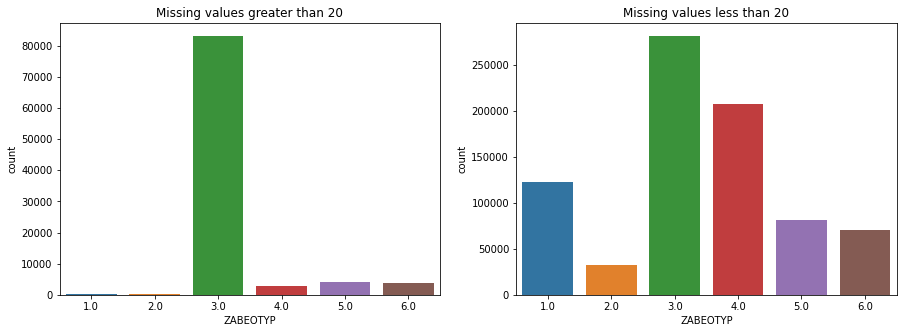

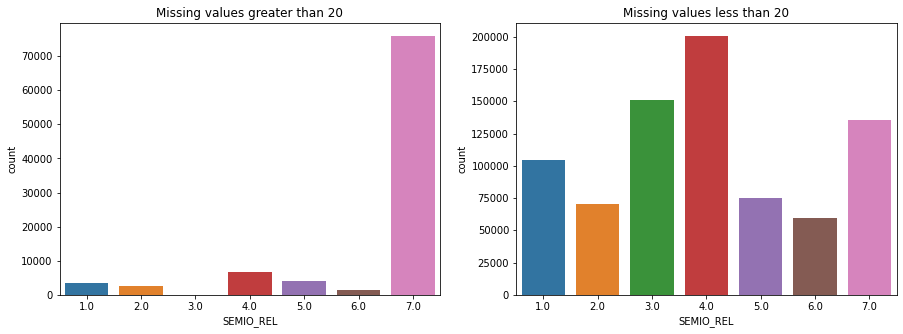

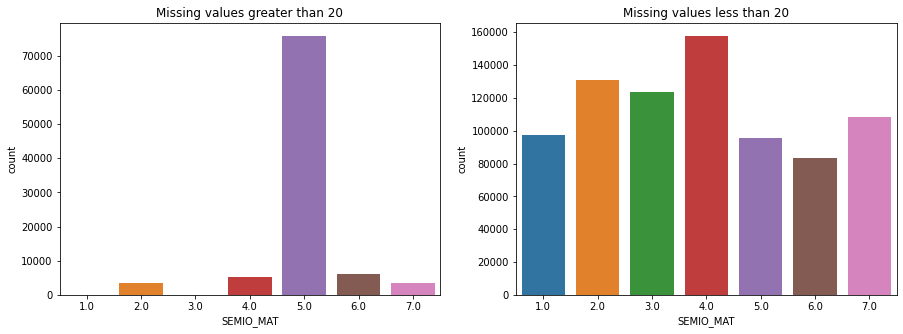

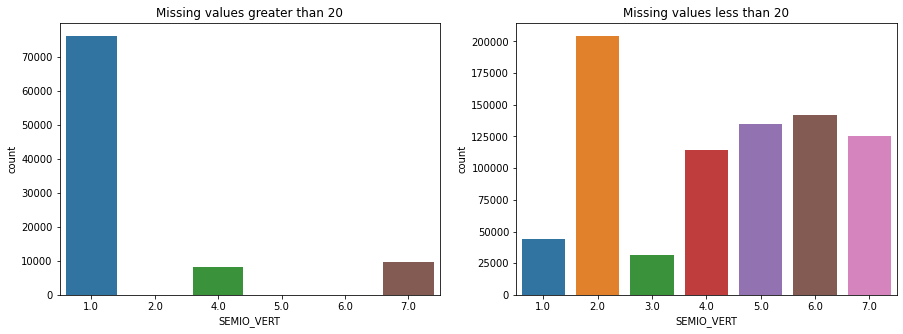

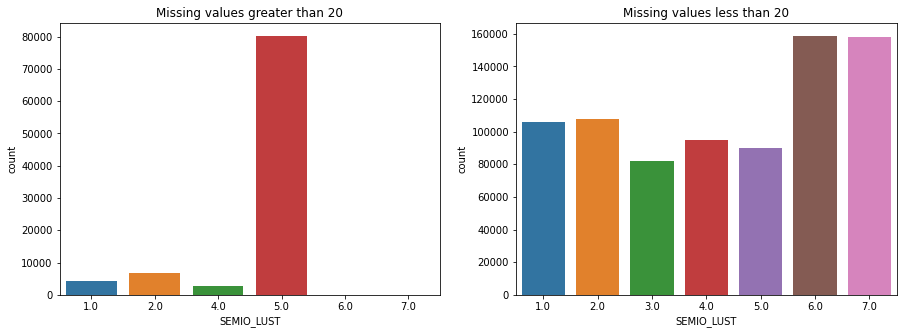

In [33]:
for col in selected_columns:
    col_dist_compare(col, missing_above_threshold, missing_below_threshold, miss_threshold)

#### Discussion 1.1.3: Assess Missing Data in Each Row

In this section, data is devided into two subsets, one subset for data points with more than 20 missing values, and a second subset for points with less than 20 missing values. The distribution of data values on columns with no or few missing data was plotted for the two subsets. As we can see, the data distribution for many missing values subset is significantly different from data distribution with no or few missing values, therefore this data is considered special. However, I will only use the subset of the data with few or no missing values `missing_below_threshold` for the analysis and drop rows with more than 20 missing values i.e `missing_above_threshold`.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [34]:
# How many features are there of each data type?
feat_type = ["ordinal", "numeric", "interval", "categorical", "mixed"]

# Drop outlier attributes (columns) already removed from azdias dataset from feat_info dataframe
for attr in outlier_column_name:
    feat_info.drop(feat_info.loc[feat_info["attribute"] == attr].index, inplace=True)
    
for t in feat_type:
    print(f"number of features of type {t} is {len(feat_info[feat_info['type'] == t])}")

number of features of type ordinal is 49
number of features of type numeric is 6
number of features of type interval is 0
number of features of type categorical is 18
number of features of type mixed is 6


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [35]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
dict_attribute_type = {}
for t in feat_type:
    dict_attribute_type[t] = feat_info.loc[feat_info['type'] == t, 'attribute'].tolist()
    
for attr in dict_attribute_type["categorical"]:
    print(f"Unique values of attribute {attr} is {missing_below_threshold[attr].dropna().unique()}", end="\n\n")

Unique values of attribute ANREDE_KZ is [2. 1.]

Unique values of attribute CJT_GESAMTTYP is [5. 3. 2. 4. 1. 6.]

Unique values of attribute FINANZTYP is [1. 6. 5. 2. 4. 3.]

Unique values of attribute GFK_URLAUBERTYP is [10.  1.  5. 12.  9.  3.  8. 11.  4.  2.  7.  6.]

Unique values of attribute GREEN_AVANTGARDE is [0. 1.]

Unique values of attribute LP_FAMILIE_FEIN is [ 5.  1. 10.  2.  7. 11.  8.  4.  6.  9.  3.]

Unique values of attribute LP_FAMILIE_GROB is [3. 1. 5. 2. 4.]

Unique values of attribute LP_STATUS_FEIN is [ 2.  3.  9.  4.  1. 10.  5.  8.  6.  7.]

Unique values of attribute LP_STATUS_GROB is [1. 2. 4. 5. 3.]

Unique values of attribute NATIONALITAET_KZ is [1. 3. 2.]

Unique values of attribute SHOPPER_TYP is [3. 2. 1. 0.]

Unique values of attribute SOHO_KZ is [1. 0.]

Unique values of attribute VERS_TYP is [2. 1.]

Unique values of attribute ZABEOTYP is [5. 3. 4. 1. 6. 2.]

Unique values of attribute GEBAEUDETYP is [8. 1. 3. 2. 6. 4. 5.]

Unique values of attribute 

In [36]:
# Re-encode categorical variable(s) to be kept in the analysis.

# binary attributes that are numeric and will be kept without encoding
binary_numeric = ["ANREDE_KZ", "GREEN_AVANTGARDE", "SOHO_KZ", "VERS_TYP"]

# binary attribute that is non-numeric and will be re-encoded to numeric values
binary_non_numeric = "OST_WEST_KZ"

# multi-level categorical attributes
multi_level_cat = ["CJT_GESAMTTYP", "FINANZTYP", "GFK_URLAUBERTYP", "LP_FAMILIE_FEIN", "LP_FAMILIE_GROB", "LP_STATUS_FEIN", "LP_STATUS_GROB", "NATIONALITAET_KZ", "SHOPPER_TYP", "ZABEOTYP", "GEBAEUDETYP", "CAMEO_DEUG_2015"]

# re-encoding OST_WEST_KZ 
missing_below_threshold[binary_non_numeric] = missing_below_threshold[binary_non_numeric].map({'W': 0, 'O':1})
print(f"unique values of OST_WEST_KZ after encoding is {missing_below_threshold['OST_WEST_KZ'].dropna().unique()}")

# re-encode numeric binary attributes VERS_TYP, ANREDE_KZ to 0 and 1
missing_below_threshold["VERS_TYP"] = missing_below_threshold["VERS_TYP"].map({1: 0, 2:1})
print(f"unique values of VERS_TYP after encoding is {missing_below_threshold['VERS_TYP'].dropna().unique()}")

missing_below_threshold["ANREDE_KZ"] = missing_below_threshold["ANREDE_KZ"].map({1: 0, 2:1})
print(f"unique values of ANREDE_KZ after encoding is {missing_below_threshold['ANREDE_KZ'].dropna().unique()}")


unique values of OST_WEST_KZ after encoding is [0 1]
unique values of VERS_TYP after encoding is [1. 0.]
unique values of ANREDE_KZ after encoding is [1 0]


In [37]:
# drop CAMEO_DEU_2015 from azdias dataset as it has  44 distinct values and this attribute is captured by CAMEO_DEUG_2015 
print(f"number of distinct values of CAMEO_DEU_2015 is {missing_below_threshold['CAMEO_DEU_2015'].nunique()}")
azdias_cleaned = missing_below_threshold.drop(columns='CAMEO_DEU_2015')

azdias_cleaned.head()


number of distinct values of CAMEO_DEU_2015 is 44


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,1,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,10.0,0.0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,3.0,1.0,1.0,5.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,0,4.0,8,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,1,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,10.0,1.0,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,2.0,0.0,0.0,5.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,0,2.0,4,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,1,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,1.0,0.0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,0,7.0,2,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,5.0,0.0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,2.0,0.0,1.0,4.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,0,3.0,6,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,1,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,1.0,0.0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,3.0,2.0,4.0,7.0,4.0,2.0,2.0,2.0,5.0,7.0,4.0,4.0,4.0,7.0,6.0,0.0,0.0,1.0,4.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,0,7.0,8,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [38]:
# perform one-hot-encoding to get dummy variables for multiple categorical features
azdias_with_dmy = pd.get_dummies(azdias_cleaned, columns=multi_level_cat)

print(f"shape of azdias dataset after creating dummy variables is {azdias_with_dmy.shape}")

azdias_with_dmy.head()

shape of azdias dataset after creating dummy variables is (797077, 150)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,...,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9
1,1.0,1,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,21.0,6.0,14.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,1.0,1.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0,...,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,3.0,1,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,3.0,1.0,15.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,0.0,0.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,0,...,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,4.0,1,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,NaN,NaN,8.0,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,0.0,0.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,0,...,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,3.0,0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,32.0,10.0,8.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,0.0,1.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,0,...,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5,1.0,1,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,8.0,2.0,3.0,3.0,2.0,4.0,7.0,4.0,2.0,2.0,2.0,5.0,7.0,4.0,4.0,4.0,7.0,6.0,0.0,1.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,0,...,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


#### Discussion 1.2.1: Re-Encode Categorical Features

Atrributes `ANREDE_KZ`, `GREEN_AVANTGARDE`, `SOHO_KZ`, `VERS_TYP` are binary (two-level) categoricals that take numeric values . I re-encoded `VERS_TYP` and  `ANREDE_KZ` and mapped them to 0 and 1.

Attribute `OST_WEST_KZ` is binary but it takes on non-numeric values. So, values are re-encoded to 0 and 1.

Attribute `CAMEO_DEU_2015` was dropped from azdias dataset as it has  44 distinct values and this attribute is already captured by `CAMEO_DEUG_2015`.

I performed one-hot-encoding to get dummy variables for multiple categorical features `"CJT_GESAMTTYP", "FINANZTYP", "GFK_URLAUBERTYP", "LP_FAMILIE_FEIN", "LP_FAMILIE_GROB", "LP_STATUS_FEIN", "LP_STATUS_GROB", "NATIONALITAET_KZ", "SHOPPER_TYP", "ZABEOTYP", "GEBAEUDETYP", "CAMEO_DEUG_2015"`

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [39]:
# mixed attributes
feat_info[feat_info["type"] == "mixed"]

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [40]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# handeling attributes with mixed data types
decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
movement_dict = {1:0, 2:1, 3:0, 4:1, 5:0 , 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}

azdias_with_dmy["PRAEGENDE_JUGENDJAHRE_decade"] = azdias_with_dmy["PRAEGENDE_JUGENDJAHRE"].replace(to_replace=decade_dict)
azdias_with_dmy["PRAEGENDE_JUGENDJAHRE_movement"] = azdias_with_dmy["PRAEGENDE_JUGENDJAHRE"].replace(to_replace=movement_dict)

azdias_mixed1_fixed = azdias_with_dmy.drop(columns="PRAEGENDE_JUGENDJAHRE")


In [41]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
print(f"type of CAMEO_INTL_2015 values {type(azdias_mixed1_fixed['CAMEO_INTL_2015'].iloc[0])}")

wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1,
               '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3,
               '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5}
life_dict = {'11':1, '12':2, '13':3, '14':4, '15':5,
               '21':1, '22':2, '23':3, '24':4, '25':5,
               '31':1, '32':2, '33':3, '34':4, '35':5,
               '41':1, '42':2, '43':3, '44':4, '45':5,
               '51':1, '52':2, '53':3, '54':4, '55':5}


azdias_mixed1_fixed["CAMEO_INTL_2015_wealth"] = azdias_mixed1_fixed["CAMEO_INTL_2015"].replace(to_replace=wealth_dict)
azdias_mixed1_fixed["CAMEO_INTL_2015_life"] = azdias_mixed1_fixed["CAMEO_INTL_2015"].replace(to_replace=life_dict)

azdias_mixed2_fixed = azdias_mixed1_fixed.drop(columns="CAMEO_INTL_2015")

type of CAMEO_INTL_2015 values <class 'str'>


#### Discussion 1.2.2: Engineer Mixed-Type Features

Here we have divided two mixed type features into more features and dropped the original feature columns from the data. I used Data_Dictionary.md to get detailed description of features .

`PRAEGENDE_JUGENDJAHRE_decade` and `PRAEGENDE_JUGENDJAHRE_movement` were created from `PRAEGENDE_JUGENDJAHRE` to capture decade and movement dimention of this feature.

`CAMEO_INTL_2015_wealth` and `CAMEO_INTL_2015_life` were created from `CAMEO_INTL_2015` to capture wealth and life stage dimention of this feature.

Then, `PRAEGENDE_JUGENDJAHRE` and `CAMEO_INTL_2015` were dropped from the dataset.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [42]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

azdias_mixed2_fixed.isna().sum().sum()

864544

In [43]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
if "CAMEO_INTL_2015" and "PRAEGENDE_JUGENDJAHRE" not in azdias_mixed2_fixed.columns.values.tolist():
    print("CAMEO_INTL_2015 and PRAEGENDE_JUGENDJAHRE are dropped from Azdias dataset")




CAMEO_INTL_2015 and PRAEGENDE_JUGENDJAHRE are dropped from Azdias dataset


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [44]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    # Load in the feature summary file.
    feat_info = pd.read_csv('/content/drive/MyDrive/Identify-Customer-Segments-Unsupervised/AZDIAS_Feature_Summary.csv', sep=';')
    
    # Identify missing or unknown data values and convert them to NaNs.
    # Convert missing_or_unknown column values from str to list
    feat_info_int = feat_info.copy() # deep copy needed when changing new df does not change the old one
    for i in range(len(feat_info)):
        missing_or_unknown_str = feat_info.loc[i,'missing_or_unknown'][1:-1].split(',')
        missing_or_unknown_list = [int(i) if i.isnumeric() or i.lstrip('-').isnumeric() else i for i in missing_or_unknown_str ]
        feat_info_int.loc[i,'missing_or_unknown'] = missing_or_unknown_list
    
    # Convert Missing Value Codes in azdias dataset to numpy NaNs 
    df_copy = df.copy()
    for i in range(len(feat_info_int)):
        miss_list = feat_info_int.loc[i, 'missing_or_unknown']
        attr_name = feat_info_int.loc[i, 'attribute']
        for miss_val in miss_list:
            df_copy.loc[df[attr_name] == miss_val , attr_name] = np.nan
            
            
    
    # remove selected columns and rows, ...
    
    # Perform an assessment of how much missing data there is in each column of the dataset.
    # Number of total missing or unknown data  for each attribute in azdias dataset after converting missing value codes to NaNs
    missing_num = df_copy.isnull().sum(axis = 0) #, columns=['attribute', 'number of missing data'])#.tolist()

    # Find percentage of data missing in each column
    missing_data_percentage = missing_num / df_copy.shape[0] * 100
    
    # Remove the outlier columns from the dataset.
    # Find number of columns that have more than 25% missing data
    # outlier_column_name = missing_data_percentage.loc[missing_data_percentage>25].index.tolist()
    outlier_column_name = ['ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP', 'TITEL_KZ']
    df_outlier_col_removed = df_copy.drop(columns=outlier_column_name)
    
    # How much data is missing in each row of the dataset?
    missing_num_row = df_outlier_col_removed.isnull().sum(axis=1)
    missing_row_percent = missing_num_row / df_outlier_col_removed.shape[1] * 100
    
    # divide the data into two subsets based on the number of missing values in each row.
    miss_threshold = 20
    missing_below_threshold = df_outlier_col_removed[(missing_num_row < miss_threshold)] 
    missing_above_threshold = df_outlier_col_removed[missing_num_row >= miss_threshold]
    
    
    
    # select, re-encode, and engineer column values.
    feat_type = ["ordinal", "numeric", "interval", "categorical", "mixed"]

    # Drop outlier attributes (columns) already removed from azdias dataset from feat_info dataframe
    for attr in outlier_column_name:
        feat_info.drop(feat_info.loc[feat_info["attribute"] == attr].index, inplace=True)
    
    # Assess categorical variables: which are binary, which are multi-level, and
    # which one needs to be re-encoded?
    dict_attribute_type = {}
    for t in feat_type:
        dict_attribute_type[t] = feat_info.loc[feat_info['type'] == t, 'attribute'].tolist()
    
    #for attr in dict_attribute_type["categorical"]:
    #    print(f"Unique values of attribute {attr} is {azdias_fillna[attr].unique()}", end="\n\n")
    
    # re-encoding OST_WEST_KZ 
    missing_below_threshold['OST_WEST_KZ'] = missing_below_threshold['OST_WEST_KZ'].map({'W': 0, 'O':1})

    # re-encode numeric binary attributes VERS_TYP, ANREDE_KZ to 0 and 1
    missing_below_threshold["VERS_TYP"] = missing_below_threshold["VERS_TYP"].map({1: 0, 2:1})

    missing_below_threshold["ANREDE_KZ"] = missing_below_threshold["ANREDE_KZ"].map({1: 0, 2:1})
    
    # drop CAMEO_DEU_2015 from azdias dataset as it has  44 distinct values and this attribute is captured by CAMEO_DEUG_2015 
    df_cleaned = missing_below_threshold.drop(columns='CAMEO_DEU_2015')
    
    # multi-level categorical attributes
    multi_level_cat = ["CJT_GESAMTTYP", "FINANZTYP", "GFK_URLAUBERTYP", "LP_FAMILIE_FEIN", "LP_FAMILIE_GROB", "LP_STATUS_FEIN", "LP_STATUS_GROB", "NATIONALITAET_KZ", "SHOPPER_TYP", "ZABEOTYP", "GEBAEUDETYP", "CAMEO_DEUG_2015"]
    # perform one-hot-encoding to get dummy variables for multiple categorical features
    df_with_dmy = pd.get_dummies(df_cleaned, columns=multi_level_cat)
    
    
    
    
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    # handeling attributes with mixed data types
    decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    movement_dict = {1:0, 2:1, 3:0, 4:1, 5:0 , 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}

    df_with_dmy["PRAEGENDE_JUGENDJAHRE_decade"] = df_with_dmy["PRAEGENDE_JUGENDJAHRE"].replace(to_replace=decade_dict)
    df_with_dmy["PRAEGENDE_JUGENDJAHRE_movement"] = df_with_dmy["PRAEGENDE_JUGENDJAHRE"].replace(to_replace=movement_dict)
    df_mixed1_fixed = df_with_dmy.drop(columns="PRAEGENDE_JUGENDJAHRE")
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1,
                   '21':2, '22':2, '23':2, '24':2, '25':2,
                   '31':3, '32':3, '33':3, '34':3, '35':3,
                   '41':4, '42':4, '43':4, '44':4, '45':4,
                   '51':5, '52':5, '53':5, '54':5, '55':5}
    life_dict = {'11':1, '12':2, '13':3, '14':4, '15':5,
                   '21':1, '22':2, '23':3, '24':4, '25':5,
                   '31':1, '32':2, '33':3, '34':4, '35':5,
                   '41':1, '42':2, '43':3, '44':4, '45':5,
                   '51':1, '52':2, '53':3, '54':4, '55':5}

    df_mixed1_fixed["CAMEO_INTL_2015_wealth"] = df_mixed1_fixed["CAMEO_INTL_2015"].replace(to_replace=wealth_dict)
    df_mixed1_fixed["CAMEO_INTL_2015_life"] = df_mixed1_fixed["CAMEO_INTL_2015"].replace(to_replace=life_dict)
    df_mixed2_fixed = df_mixed1_fixed.drop(columns="CAMEO_INTL_2015")

    
    
    # Return the cleaned dataframe.
    return df_mixed2_fixed
    

In [45]:
clean_data_azdias = clean_data(azdias)

In [46]:
clean_data_azdias.shape

(797077, 152)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [50]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

#from sklearn.preprocessing import Imputer
# Imputer was deprecated with scikit-learn v0.20.4 and removed as of v0.22.2. As of scikit-learn v0.20, SimpleImputer replaces the previous sklearn.preprocessing.Imputer estimator.
from sklearn.impute import SimpleImputer

print(f"number of missing values in the azdias dataset after preprocessing is {azdias_mixed2_fixed.isna().sum().sum()}")

imputer = SimpleImputer(strategy='most_frequent')
azdias_imputed = pd.DataFrame(imputer.fit_transform(azdias_mixed2_fixed), columns=azdias_mixed2_fixed.columns)

print(f"number of missing values in the azdias dataset after imputation is {azdias_imputed.isna().sum().sum()}")

number of missing values in the azdias dataset after preprocessing is 864544
number of missing values in the azdias dataset after imputation is 0


In [51]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
std_scaler.fit(azdias_imputed)
azdias_scaled = std_scaler.transform(azdias_imputed)
azdias_scaled_df = pd.DataFrame(azdias_scaled, columns=azdias_imputed.columns.tolist())

azdias_scaled_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,...,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_life
0,-1.766173,0.958121,-1.494463,1.538139,-1.040664,1.466401,0.959974,1.338532,-0.530654,1.010291,0.454767,0.331494,-1.684892,0.442419,-0.059134,0.003319,-0.463253,-1.685220,-1.109821,-1.435509,-0.578571,1.274161,-0.311629,1.339150,-0.157497,1.517954,1.288519,10.855531,0.922883,0.233692,-0.060579,1.025749,-0.729696,0.566381,0.172669,-0.125151,-1.304315,-0.383149,-0.517521,-0.027783,...,-0.454029,-0.403362,1.228109,-0.521262,-0.223953,-0.490845,-0.403362,0.440886,-0.294514,-0.206295,-0.435573,-0.670394,-0.590109,1.847538,-0.427721,-0.207633,-0.739463,-0.593025,2.975499,-0.312265,-1.167724,-0.077747,-0.537197,-0.03334,-0.00112,-0.02772,2.056411,-0.218058,-0.341273,-0.349155,-0.386971,-0.272817,-0.391257,-0.329089,2.220562,-0.396186,1.098802,-0.530654,1.175857,-1.249369
1,0.200733,0.958121,-1.494463,0.864753,-1.766903,-0.570914,0.245238,1.338532,1.884467,1.010291,-0.996716,-1.020896,-0.310441,-0.072758,-1.626956,-0.520178,-0.463253,-0.142659,-0.158824,0.754224,-0.578571,0.064325,1.393241,1.339150,1.448591,-0.638498,-0.410737,-0.092119,-1.083561,-0.631113,-0.060579,-0.268726,-0.729696,0.566381,0.108697,-0.125151,1.275123,-0.383149,-0.517521,-1.054519,...,-0.454029,-0.403362,-0.814260,1.918423,-0.223953,-0.490845,-0.403362,0.440886,-0.294514,-0.206295,-0.435573,-0.670394,1.694601,-0.541261,-0.427721,-0.207633,-0.739463,-0.593025,2.975499,-0.312265,0.856367,-0.077747,-0.537197,-0.03334,-0.00112,-0.02772,-0.486284,-0.218058,-0.341273,-0.349155,2.584170,-0.272817,-0.391257,-0.329089,-0.450336,-0.396186,1.098802,1.884467,-0.869590,0.766691
2,1.184186,0.958121,0.683285,-0.482020,1.138052,-0.570914,-1.184235,-0.792444,-0.530654,-0.311793,-1.157992,-0.750418,-0.997667,0.442419,-1.626956,-1.043675,-1.508398,-0.142659,-0.158824,1.301657,-0.067846,-0.540594,-0.311629,-0.303505,0.377866,-0.099385,0.155682,-0.092119,-1.083561,-1.495919,-0.060579,-2.210438,0.957646,0.566381,-0.467054,-0.125151,0.630264,1.139883,-0.517521,1.512320,...,2.202500,-0.403362,-0.814260,-0.521262,-0.223953,2.037304,-0.403362,0.440886,-0.294514,-0.206295,-0.435573,1.491659,-0.590109,-0.541261,-0.427721,-0.207633,1.352332,-0.593025,-0.336078,-0.312265,0.856367,-0.077747,-0.537197,-0.03334,-0.00112,-0.02772,-0.486284,-0.218058,2.930210,-0.349155,-0.386971,-0.272817,-0.391257,-0.329089,-0.450336,-0.396186,-0.267171,-0.530654,-1.551406,-0.577349
3,0.200733,-1.043709,0.683285,0.191366,0.411813,-1.250019,0.245238,-0.792444,-0.530654,1.010291,1.341784,1.413406,1.064009,0.957596,-0.059134,0.003319,-0.985825,1.399902,-0.158824,-0.340642,0.953604,-1.145512,-0.879919,-1.398609,-1.228222,-0.099385,-0.977156,-0.092119,0.922883,1.963302,-0.060579,0.378511,-1.292143,0.566381,-0.339109,-0.125151,0.630264,-0.383149,-0.517521,-0.541151,...,-0.454029,-0

In [52]:
azdias_scaled_df.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,...,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_life
count,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,...,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05,7.970770e+05
mean,-3.091487e-15,-4.249561e-15,6.507383e-15,-7.421211e-15,1.055894e-14,-1.742166e-14,4.904881e-16,2.894385e-15,2.236885e-14,-5.943510e-16,-4.442644e-16,3.280976e-16,-7.098557e-15,-5.961716e-16,6.605140e-15,2.720539e-15,9.765963e-16,-2.852109e-15,-2.640976e-15,-9.086604e-16,2.459636e-15,-3.307662e-15,-3.913889e-16,1.375969e-15,1.499371e-15,3.859033e-16,-9.046230e-16,3.633089e-15,-1.215779e-14,8.940601e-15,4.106510e-15,-1.354312e-14,-6.420258e-15,-1.525739e-14,-1.237331e-15,9.562778e-15,6.099825e-15,-7.316799e-14,-1.283865e-13,-5.965614e-15,...,-9.175501e-15,-4.009404e-14,1.542679e-14,-1.503333e-14,3.803022e-15,2.242758e-14,-4.009404e-14,-4.143782e-15,-6.473002e-15,-8.605736e-15,-1.288987e-15,2.166243e-15,3.311710e-15,-1.203014e-15,1.427337e-14,-1.636184e-14,4.406394e-17,-1.748472e-15,-7.634119e-15,3.991573e-15,-5.684558e-15,-5.526965e-15,-1.191975e-14,-1.417479e-14,-1.390299e-14,3.420914e-15,-1.475317e-14,-1.796525e-14,-5.107357e-15,3.010978e-15,1.057355e-14,2.694329e-14,3.360800e-15,-4.294856e-15,1.026926e-14,8.651026e-15,-3.001449e-16,2.236885e-14,-3.788460e-15,-2.623375e-15
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,

### Discussion 2.1: Apply Feature Scaling

In this section, I used SimpleImputer to replace missing data with the most frequent value along each column. Then, I used StandardScaler to scale data to mean 0 and standard deviation of 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [53]:
# Apply PCA to the data.

pca = PCA()
azdias_pca = pca.fit_transform(azdias_scaled_df)

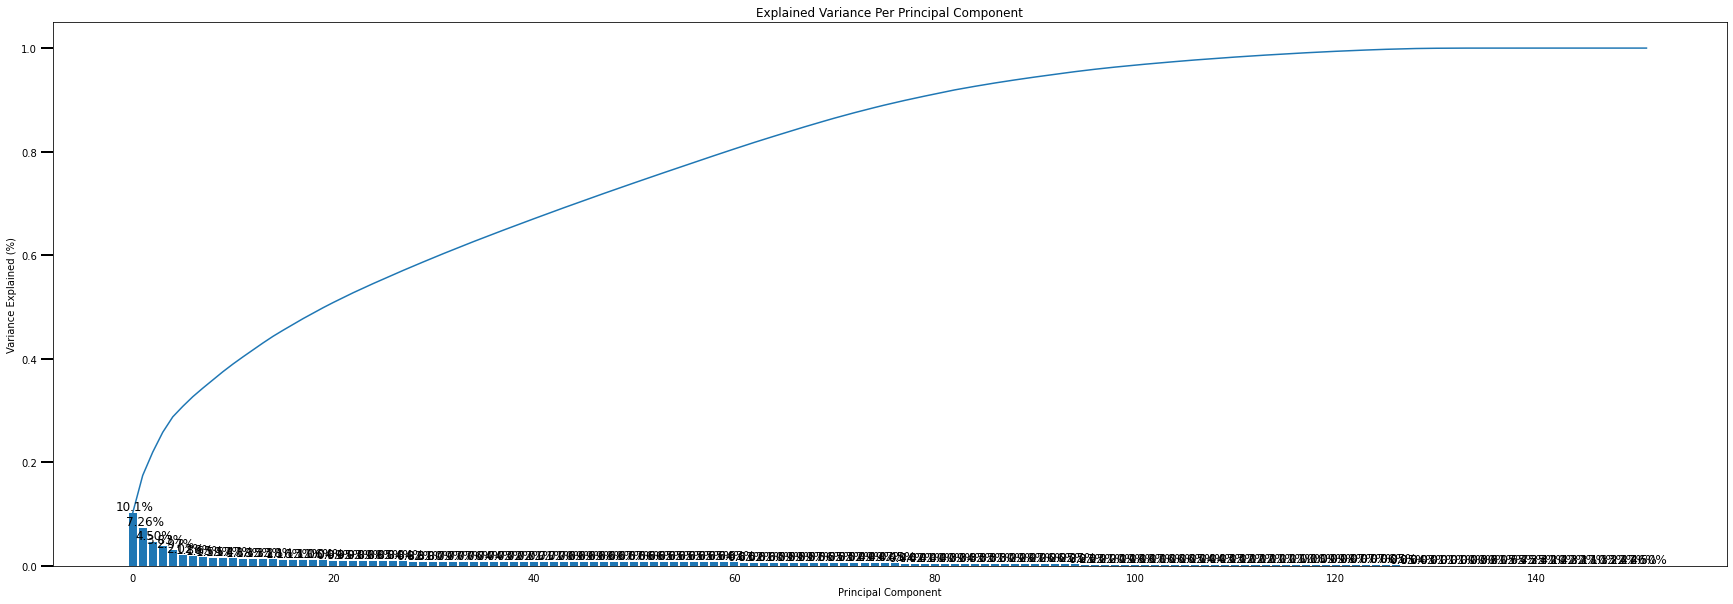

In [54]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(30, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')


scree_plot(pca)

In [55]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components=60)
azdias_pca = pca.fit_transform(azdias_scaled_df)

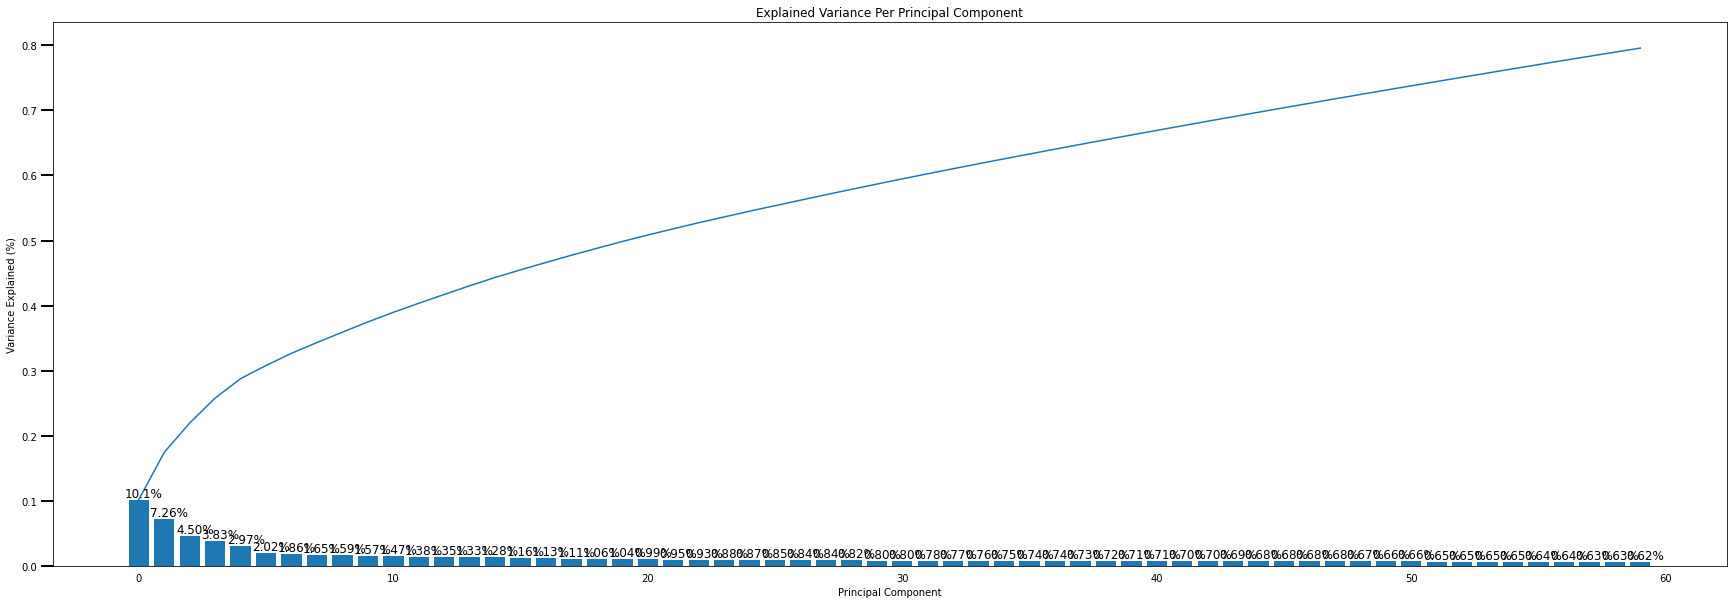

In [56]:
scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction 

In this section, principle components were calculated and 60 components that could explain 80% cumulative variability in the original features were kept for the next step of the analysis .

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

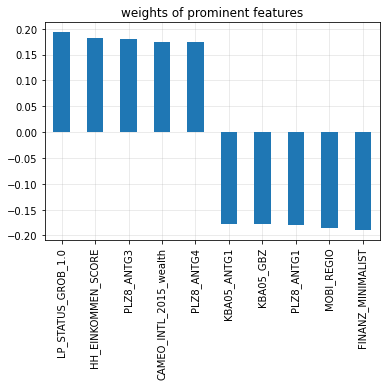

In [57]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_weights(df,pca,n):
    weights_df=pd.DataFrame(pca.components_,columns=list(df.columns)).iloc[n]
    weights_df.sort_values(ascending=False, inplace=True)
    return weights_df

def plot_weights(weights_df):

    prom_weights = pd.concat([weights_df.head(5), weights_df.tail(5)])
    
    prom_weights.plot(kind='bar', title='weights of prominent features')
    ax = plt.gca()
    ax.grid(linewidth='0.5', alpha=0.5)
    ax.set_axisbelow(True)
    plt.show()



pcomponent_weights_0 = pca_weights(azdias_scaled_df, pca, 0)
plot_weights(pcomponent_weights_0)

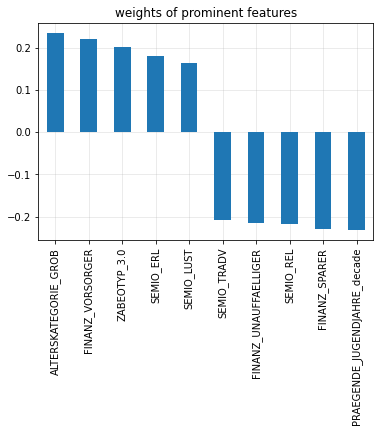

In [58]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pcomponent_weights_1 = pca_weights(azdias_scaled_df, pca, 1)
plot_weights(pcomponent_weights_1)

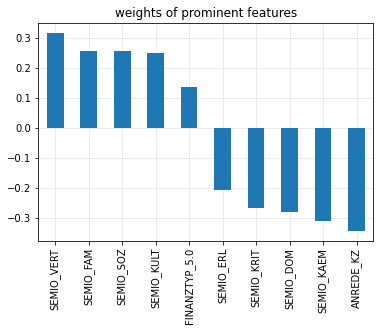

In [59]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pcomponent_weights_2 = pca_weights(azdias_scaled_df, pca, 2)
plot_weights(pcomponent_weights_2)

### Discussion 2.3: Interpret Principal Components

The first principal component explains variance in features related to number of buildings, family, social status, income, and wealth. This principle componenthas has largest positive weights associated with `LP_STATUS_GROB_1.0 (Social status:low-income earners)`, `HH_EINKOMMEN_SCORE (Estimated household net income)`, `PLZ8_ANTG4(Number of 10+ family houses in the PLZ8 region
)`, `PLZ8_ANTG3(Number of 6-10 family houses in the PLZ8 region)`, and `CAMEO_INTL_2015_wealth (German CAMEO: Wealth)` and negative weights associated with `FINANZ_MINIMALIST(Financial typology:low financial interest)`, `MOBI_REGIO(Movement patterns)`, `PLZ8_ANTG1(Number of 1-2 family houses in the PLZ8 region)`, `KBA05_GBZ(Number of buildings in the microcell)`, and `KBA05_ANTG1 (Number of 1-2 family houses in the microcell)`. 
 
The second principal component explains variance in features related to financial typology, personality typology, age, energy consumption, and decade. This principle componenthas has largest positive weights associated with `ALTERSKATEGORIE_GROB(Estimated age based on given name analysis)`, `FINANZ_VORSORGER(Financial typology:be prepared)`, `ZABEOTYP_3.0(Energy consumption typology:fair supplied)`, `SEMIO_ERL(Personality typology:event-oriented)`, and `SEMIO_LUST (Personality topology:sensual-minded)` and negative weights associated with `PRAEGENDE_JUGENDJAHRE_decade(generation)`, `FINANZ_SPARER(Financial typology:money-saver)`, `FINANZ_UNAUFFAELLIGER(Financial typology:inconspicuous)`, `SEMIO_REL(Personality typology:religious)`, and `SEMIO_TRADV (Personality:tradional-minded)`. 


The third principal component explains variance in features related to personality typology and gender. This principle componenthas has largest positive weights associated with `SEMIO_VERT(Personality typology:dreamful)`, `SEMIO_FAM (Personality typology:family-minded)`, `SEMIO_SOZ (Personality typology:socially-minded)`, `SEMIO_KULT(Personality typology:cultural-minded)`, and `FINANZTYP_5 (financial type:investor)` and negative weights associated with `ANREDE_KZ(Gender:femal,male)`, `SEMIO_KAEM (Personality typology:combative attitude)`, `SEMIO_DOM (Personality typology:dominant-minded)`, `SEMIO_KRIT (Personality typology:critical-minded)`, and `SEMIO_ERL (Personality typology:event-oriented)`. 

In general, if the feature with positive weight goes up , the feature with negative weight goes down. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [60]:
# Over a number of different cluster counts...
from time import time

cluster_count=np.arange(1,21)
scores=[]
for k in cluster_count:
  # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=k)
    model = kmeans.fit(azdias_pca)
    # compute the average within-cluster distances.
    score = np.abs(model.score(azdias_pca))
    print(f"For {k} clusters, average within-cluster distances is {score}")
    scores.append(score)
    
    

For 1 clusters, average within-cluster distances is 96421316.40270007
For 2 clusters, average within-cluster distances is 87050363.81081015
For 3 clusters, average within-cluster distances is 82573465.93106437
For 4 clusters, average within-cluster distances is 79662095.42466748
For 5 clusters, average within-cluster distances is 77236065.58363958
For 6 clusters, average within-cluster distances is 75725825.31698105
For 7 clusters, average within-cluster distances is 74361409.01393548
For 8 clusters, average within-cluster distances is 73384886.95678353
For 9 clusters, average within-cluster distances is 71921482.8816649
For 10 clusters, average within-cluster distances is 71022267.1120277
For 11 clusters, average within-cluster distances is 70249447.88500392
For 12 clusters, average within-cluster distances is 69534312.6931244
For 13 clusters, average within-cluster distances is 68728100.66449286
For 14 clusters, average within-cluster distances is 67594711.24252033
For 15 clusters, a

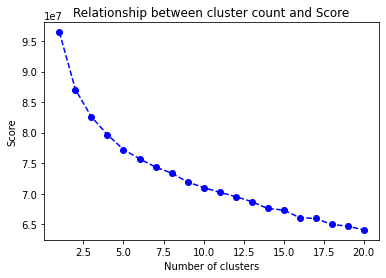

In [61]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(cluster_count, scores, linestyle='--', marker='o', color='b');
plt.xlabel('Number of clusters');
plt.ylabel('Score');
plt.title('Relationship between cluster count and Score');


In [62]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=20)
model = kmeans.fit(azdias_pca)
preds = model.predict(azdias_pca)


### Discussion 3.1: Apply Clustering to General Population

I used sklearn's KMeans class to perform k-means clustering on the PCA-transformed data and finally fitted the k-means model with number of clusters as 20 after investigating the change in within-cluster distance accross number of clusters using elbow method.


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [64]:
# Load in the customer demographics data.
customers = pd.read_csv('/content/drive/MyDrive/Identify-Customer-Segments-Unsupervised/Udacity_CUSTOMERS_Subset.csv',delimiter=';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,...,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3,0.0,...,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3,0.0,...,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,4,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1,0.0,...,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,6,0,10.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,1,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0,0.0,...,0.0,4.0,NaN,NaN,9.0,0.0,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,2,1960,2.0,0,3,31.0,10.0,10.0,5.0,1.0,1.0,1,8,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1,0.0,...,0.0,6.0,2.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,W,3.0,7,7B,41,0.0,3.0,2.0,0.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [65]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
clean_customers = clean_data(customers)
clean_customers.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,...,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_life
0,4.0,0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,20.0,5.0,5.0,6.0,5.0,2.0,6.0,6.0,7.0,3.0,4.0,1.0,3.0,1.0,1.0,2.0,1.0,0.0,0.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,5.0,1992.0,0,7.0,...,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2.0,1.0,1.0,3.0
2,4.0,1,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,13.0,3.0,5.0,2.0,2.0,1.0,3.0,3.0,7.0,7.0,1.0,2.0,7.0,5.0,6.0,4.0,1.0,0.0,1.0,1.0,0.0,1.0,6.0,9.0,1.0,0.0,1.0,1992.0,0,2.0,...,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,2.0,1.0,3.0,4.0
3,4.0,0,5.0,1.0,5.0,2.0,1.0,2.0,0.0,2.0,NaN,NaN,3.0,6.0,5.0,3.0,4.0,7.0,5.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0,4.0,0.0,0.0,0.0,0.0,4.0,NaN,9.0,NaN,NaN,2.0,1992.0,0,7.0,...,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1.0,0.0,2.0,4.0
4,3.0,0,3.0,1.0,4.0,4.0,5.0,2.0,0.0,3.0,31.0,10.0,5.0,4.0,5.0,4.0,6.0,5.0,6.0,4.0,5.0,5.0,3.0,5.0,2.0,5.0,4.0,0.0,1.0,4.0,0.0,6.0,2.0,9.0,7.0,0.0,1.0,1992.0,0,3.0,...,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,4.0,0.0,4.0,1.0
5,3.0,0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,17.0,5.0,3.0,6.0,4.0,4.0,1.0,7.0,6.0,4.0,6.0,2.0,5.0,5.0,3.0,3.0,4.0,0.0,1.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,2.0,1992.0,0,1.0,...,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2.0,1.0,3.0,4.0


In [66]:
clean_customers.shape

(141590, 151)

In [67]:
clean_data_azdias.shape

(797077, 152)

In [68]:
set(clean_data_azdias.columns)-set(clean_customers.columns)

{'GEBAEUDETYP_5.0'}

In [69]:
clean_customers['GEBAEUDETYP_5.0'] = 0
clean_customers.shape

(141590, 152)

In [70]:
# Clean customer dataset of all missing values via imputation
print(f"number of missing values in the costumer dataset after preprocessing is {clean_customers.isna().sum().sum()}")

customer_imputed = pd.DataFrame(imputer.transform(clean_customers), columns=clean_customers.columns)

print(f"number of missing values in the azdias dataset after imputation is {customer_imputed.isna().sum().sum()}")

number of missing values in the costumer dataset after preprocessing is 124147
number of missing values in the azdias dataset after imputation is 0


In [71]:
# Feature transformation
clean_scaled_customers = std_scaler.transform(customer_imputed)
clean_scaled_customers_df = pd.DataFrame(clean_scaled_customers, columns=customer_imputed.columns.tolist())
customers_pca = pca.transform(clean_scaled_customers_df)


In [72]:
# customer data clustering 
customer_preds = model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

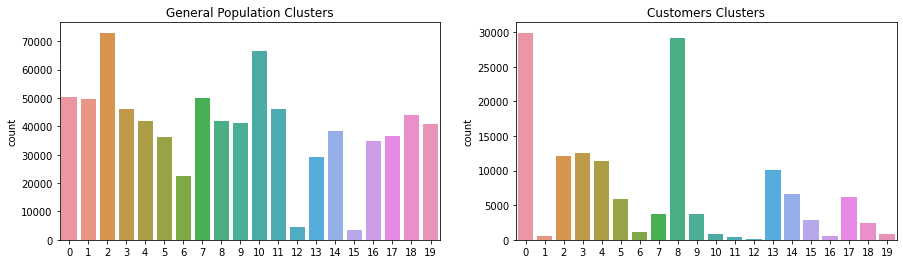

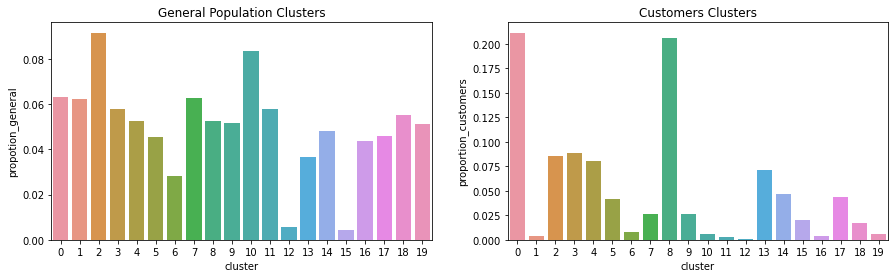

In [73]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
def count_cluster(azdias_preds,customers_preds):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(15)
    ax1.set_title('General Population Clusters')
    sns.countplot(azdias_preds,ax=ax1)

    ax2.set_title('Customers Clusters')
    sns.countplot(customers_preds,ax=ax2)
    plt.show()

def proportion_plot(azdias_preds, customers_preds):
    general_pp = []
    customers_pp = []

    for i in range(20):
        general_pp.append((azdias_preds == i).sum()/len(azdias_preds))
        customers_pp.append((customers_preds == i).sum()/len(customers_preds))

    df = pd.DataFrame({'cluster' : list(range(0,20)), 'propotion_general' : general_pp, 'proportion_customers':customers_pp})
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(15)

    ax1.set_title('General Population Clusters')
    ax = sns.barplot(x='cluster', y='propotion_general' ,ax=ax1, data=df)

    ax2.set_title('Customers Clusters')
    ax = sns.barplot(x='cluster', y='proportion_customers' ,ax=ax2, data=df)


count_cluster(preds,customer_preds)
proportion_plot(preds,customer_preds)

In [118]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

customer_overrep = std_scaler.inverse_transform(pca.inverse_transform(azdias_pca[np.where(customer_preds==0)])).round()
df_overrep = pd.DataFrame(data=customer_overrep, columns=clean_customers.columns)
df_overrep.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,...,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_life,GEBAEUDETYP_5.0
0,2.0,1.0,1.0,5.0,3.0,5.0,4.0,5.0,-0.0,2.0,15.0,5.0,0.0,4.0,4.0,5.0,4.0,2.0,3.0,4.0,3.0,6.0,5.0,6.0,5.0,6.0,5.0,1.0,1.0,2.0,0.0,6.0,3.0,9.0,31.0,0.0,2.0,1990.0,-0.0,3.0,...,0.0,-0.0,1.0,0.0,0.0,-0.0,-0.0,1.0,0.0,0.0,1.0,-0.0,-0.0,0.0,-0.0,1.0,-0.0,-0.0,1.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,1.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,1.0,0.0,6.0,-0.0,6.0,1.0
1,3.0,1.0,2.0,4.0,3.0,3.0,4.0,3.0,1.0,2.0,4.0,1.0,3.0,2.0,2.0,3.0,3.0,3.0,4.0,6.0,2.0,4.0,6.0,7.0,6.0,4.0,4.0,-0.0,0.0,1.0,0.0,4.0,4.0,8.0,5.0,0.0,4.0,1993.0,-0.0,2.0,...,-0.0,0.0,0.0,1.0,-0.0,-0.0,0.0,1.0,-0.0,0.0,-0.0,-0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.0,1.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,1.0,0.0,-0.0,-0.0,0.0,-0.0,6.0,1.0,1.0,4.0
2,1.0,1.0,3.0,1.0,5.0,2.0,2.0,5.0,-0.0,3.0,8.0,2.0,4.0,4.0,4.0,6.0,3.0,3.0,1.0,3.0,5.0,6.0,5.0,5.0,5.0,7.0,6.0,0.0,1.0,1.0,0.0,5.0,6.0,8.0,0.0,-0.0,3.0,1991.0,-0.0,7.0,...,-0.0,0.0,-0.0,1.0,-0.0,-0.0,0.0,1.0,-0.0,0.0,1.0,0.0,0.0,-0.0,0.0,-0.0,0.0,1.0,-0.0,0.0,1.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,1.0,-0.0,3.0,-0.0,4.0,3.0
3,2.0,1.0,2.0,5.0,1.0,5.0,4.0,4.0,-0.0,2.0,3.0,1.0,3.0,3.0,4.0,6.0,7.0,3.0,5.0,5.0,5.0,7.0,6.0,6.0,6.0,7.0,6.0,0.0,0.0,1.0,0.0,5.0,4.0,8.0,3.0,-0.0,4.0,1990.0,0.0,3.0,...,0.0,0.0,1.0,0.0,-0.0,0.0,0.0,1.0,-0.0,0.0,-0.0,1.0,0.0,0.0,-0.0,-0.0,-0.0,1.0,0.0,0.0,1.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,1.0,0.0,-0.0,0.0,-0.0,0.0,6.0,-0.0,3.0,3.0
4,2.0,-0.0,3.0,2.0,4.0,1.0,3.0,3.0,0.0,2.0,6.0,2.0,5.0,7.0,7.0,7.0,6.0,7.0,3.0,1.0,7.0,5.0,1.0,2.0,1.0,6.0,6.0,0.0,0.0,1.0,-0.0,4.0,5.0,8.0,2.0,-0.0,3.0,1991.0,-0.0,3.0,...,0.0,0.0,1.0,-0.0,0.0,0.0,0.0,1.0,-0.0,0.0,1.0,-0.0,0.0,0.0,1.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,4.0,0.0,1.0,4.0
5,4.0,1.0,3.0,2.0,5.0,3.0,1.0,4.0,-0.0,2.0,6.0,2.0,5.0,2.0,3.0,3.0,4.0,3.0,5.0,6.0,3.0,4.0,6.0,6.0,6.0,3.0,3.0,0.0,1.0,1.0,-0.0,7.0,6.0,9.0,7.0,0.0,3.0,1992.0,0.0,4.0,...,-0.0,0.0,1.0,0.0,0.0,-0.0,0.0,1.0,-0.0,0.0,0.0,0.0,1.0,-0.0,-0.0,-0.0,1.0,-0.0,0.0,0.0,1.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,1.0,3.0,-0.0,5.0,1.0
6,2.0,1.0,4.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,11.0,3.0,5.0,3.0,3.0,5.0,3.0,2.0,4.0,5.0,4.0,6.0,6.0,7.0,7.0,6.0,5.0,-0.0,1.0,1.0,0.0,2.0,6.0,8.0,-1.0,-0.0,3.0,1993.0,0.0,2.0,...,-0.0,1.0,0.0,-0.0,0.0,-0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.0,0.0,0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,3.0,1.0,2.0,5.0
7,2.0,1.0,3.0,4.0,2.0,4.0,4.0,2.0,-0.0,2.0,8.0,3.0,2.0,3.0,4.0,6.0,6.0,3.0,4.0,5.0,5.0,7.0,6.0,6.0,6.0,7.0,7.0,0.0,0.0,1.0,0.0,5.0,4.0,8.0,-0.0,0.0,4.0,1992.0,0.0,5.0,...,1.0,-0.0,0.0,0.0,-0.0,1.0,-0.0,-0.0,1.0,0.0,-0.0,1.0,0.0,0.0,-0.0,0.0,-0.0,1.0,0.0,0.0,1.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,1.0,0.0,0.0,0.0,-0.0,

In [119]:
# Inverse transform the over represented cluster center
centroid_0 = std_scaler.inverse_transform(pca.inverse_transform(model.cluster_centers_[0]).reshape(1, -1))
cluster_center_overrep = pd.DataFrame(centroid_0, columns=clean_customers.columns)
cluster_center_overrep.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,...,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_life,GEBAEUDETYP_5.0
0,3.407475,0.48267,4.594627,1.484922,4.32439,1.617606,2.076083,2.247837,0.993919,2.083655,14.472694,3.893246,3.884993,4.06882,3.504266,3.001243,3.12311,4.706151,5.355564,5.165638,3.514924,3.073045,4.567786,4.584368,4.15387,3.143111,2.977141,0.007588,0.493499,1.348128,0.001413,2.397545,5.255443,8.39923,1.430852,-0.001453,3.407189,1992.978013,0.105769,3.199134,...,-0.007909,0.915126,0.060634,0.014101,0.006882,-0.005254,0.915126,0.947663,0.017722,0.012575,0.178731,0.259099,0.193423,0.345161,0.391701,0.09625,0.426295,0.066244,-0.015749,0.035258,0.778179,0.025506,0.063876,0.004424,0.000003,0.00248,0.125533,0.149797,0.264002,0.15656,0.168884,0.056493,0.097798,0.046966,0.034826,0.017892,3.328378,0.993919,2.093423,3.623514


In [120]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
customer_underrep = std_scaler.inverse_transform(pca.inverse_transform(azdias_pca[np.where(customer_preds==10)])).round()
df_underrep = pd.DataFrame(data=customer_underrep, columns=clean_customers.columns)
df_underrep.head(10)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,...,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_life,GEBAEUDETYP_5.0
0,2.0,0.0,4.0,2.0,4.0,3.0,2.0,1.0,-0.0,3.0,8.0,3.0,4.0,5.0,5.0,5.0,3.0,5.0,3.0,3.0,5.0,4.0,4.0,4.0,3.0,5.0,4.0,0.0,1.0,1.0,-0.0,4.0,5.0,7.0,11.0,0.0,3.0,1995.0,0.0,6.0,...,1.0,-0.0,0.0,0.0,0.0,1.0,-0.0,1.0,-0.0,-0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,1.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,5.0,-0.0,2.0,4.0
1,2.0,-0.0,4.0,2.0,4.0,1.0,2.0,3.0,0.0,2.0,15.0,4.0,5.0,6.0,7.0,6.0,6.0,6.0,3.0,3.0,7.0,5.0,3.0,4.0,3.0,5.0,5.0,0.0,1.0,2.0,-0.0,6.0,5.0,9.0,7.0,0.0,2.0,1992.0,-0.0,2.0,...,0.0,-0.0,-0.0,1.0,0.0,0.0,-0.0,-0.0,0.0,1.0,0.0,1.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,1.0,4.0,0.0,4.0,1.0
2,2.0,1.0,3.0,1.0,4.0,3.0,1.0,4.0,-0.0,3.0,5.0,1.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,-0.0,1.0,1.0,-0.0,5.0,6.0,9.0,15.0,0.0,3.0,1996.0,1.0,7.0,...,-0.0,0.0,-0.0,1.0,0.0,-0.0,0.0,1.0,0.0,-0.0,0.0,0.0,0.0,1.0,-0.0,0.0,0.0,0.0,-0.0,1.0,0.0,0.0,1.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,3.0,-0.0,2.0,5.0
3,3.0,0.0,2.0,5.0,2.0,4.0,5.0,3.0,-0.0,3.0,1.0,1.0,3.0,5.0,6.0,5.0,5.0,5.0,4.0,4.0,6.0,4.0,4.0,3.0,3.0,5.0,4.0,-0.0,1.0,1.0,0.0,6.0,5.0,8.0,6.0,-0.0,3.0,1992.0,-0.0,5.0,...,0.0,0.0,1.0,-0.0,-0.0,-0.0,0.0,1.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,1.0,0.0,1.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,1.0,6.0,-0.0,5.0,1.0
4,4.0,0.0,3.0,1.0,5.0,1.0,2.0,5.0,0.0,2.0,14.0,4.0,5.0,3.0,5.0,4.0,6.0,6.0,8.0,5.0,5.0,2.0,3.0,3.0,3.0,3.0,2.0,0.0,-0.0,2.0,-0.0,6.0,6.0,7.0,49.0,1.0,3.0,1993.0,-0.0,3.0,...,-0.0,-0.0,0.0,1.0,-0.0,0.0,-0.0,1.0,-0.0,0.0,-0.0,-0.0,1.0,-0.0,0.0,-0.0,1.0,-0.0,-0.0,0.0,-0.0,-0.0,1.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,1.0,3.0,0.0,4.0,3.0
5,3.0,1.0,2.0,3.0,4.0,2.0,3.0,4.0,-0.0,2.0,5.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0,3.0,6.0,2.0,4.0,6.0,6.0,6.0,4.0,3.0,0.0,0.0,1.0,-0.0,6.0,4.0,6.0,19.0,-0.0,3.0,1994.0,0.0,3.0,...,-0.0,-0.0,1.0,-0.0,-0.0,0.0,-0.0,1.0,0.0,-0.0,0.0,-0.0,0.0,1.0,-0.0,-0.0,1.0,0.0,0.0,-0.0,1.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,0.0,0.0,0.0,4.0,-0.0,5.0,3.0
6,2.0,0.0,3.0,4.0,2.0,5.0,5.0,2.0,0.0,3.0,29.0,9.0,3.0,6.0,7.0,7.0,5.0,6.0,4.0,3.0,7.0,4.0,3.0,2.0,2.0,6.0,5.0,-0.0,1.0,3.0,0.0,3.0,4.0,9.0,2.0,-0.0,5.0,1994.0,0.0,5.0,...,0.0,-0.0,0.0,1.0,-0.0,0.0,-0.0,1.0,-0.0,0.0,0.0,1.0,-0.0,-0.0,1.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.0,0.0,1.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,6.0,0.0,1.0,4.0
7,1.0,1.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,33.0,11.0,2.0,3.0,4.0,7.0,4.0,2.0,3.0,4.0,5.0,7.0,5.0,6.0,6.0,8.0,6.0,-0.0,1.0,4.0,0.0,5.0,2.0,8.0,8.0,-0.0,1.0,1990.0,0.0,4.0,...,0.0,0.0,1.0,0.0,-0.0,0.0,0.0,1.0,-0.0,-0.0,0.0,-0.0,1.0,-0.0,0.0,0.0,-0.0,1.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,1.0,-0.0,0.0,0.

In [121]:
# Inverse transform the under represented cluster center
centroid_10 = std_scaler.inverse_transform(pca.inverse_transform(model.cluster_centers_[10]).reshape(1, -1))
cluster_center_underrep = pd.DataFrame(centroid_10, columns=clean_customers.columns)
cluster_center_underrep.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,...,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_life,GEBAEUDETYP_5.0
0,1.800601,0.97446,1.039929,4.536163,2.138109,4.411724,3.92752,4.383611,0.036754,2.380364,2.75991,1.422005,2.594772,3.277143,3.985998,5.402667,4.681453,2.270583,3.320485,4.359142,4.092231,5.918511,5.507652,6.011384,5.999976,6.091424,5.27195,0.006334,0.566058,1.064259,0.000458,5.620664,5.038749,7.10812,14.469908,0.050403,2.134788,1992.436681,0.251569,3.411757,...,0.017684,0.000746,0.949133,0.022088,0.007664,0.016023,0.000746,0.620667,0.118881,0.106978,0.063912,0.196804,0.434232,0.144597,-0.007947,0.001174,0.148291,0.435556,0.348811,0.074115,0.412558,0.000474,0.315123,0.000069,0.000003,0.001605,0.270168,0.012194,0.024087,0.027515,0.022346,0.060204,0.110798,0.13957,0.296963,0.301169,5.786046,0.036754,4.267219,2.094693


### Discussion 3.3: Compare Customer Data to Demographics Data

By looking at the graph we can easily find that data points in the clusters 0 and 8 are highly likely customer segments because the larger proportion of customer data is present at these points. Some features of cluster 0 are:


*   The age range is most likely within 46 - 60 years old or higher (ALTERSKATEGORIE_GROB = 3.407475)
*   The social status is most likely top earners (LP_STATUS_GROB_5.0=0.915126)
*   The Family type is less likely to be single compared to the under represented segment (LP_FAMILIE_FEIN_1.0=0.552489)
*   It has lower share of 6-10 family homes in PLZ8 region (PLZ8_ANTG3=1.172808)
*   The unemployment relative to county in which community is contained is low to average (RELAT_AB=2.897986)








Data points that are in cluster 10, 1, and 11 are less likely to be turned into customers. Some features of cluster 10 are:

*   The age range is most likely within 30 - 45 years old or less (ALTERSKATEGORIE_GROB = 1.800601)
*   The social status is most likely low-income earners (LP_STATUS_GROB_1.0=0.949133)
*   The Family type is most likely single (LP_FAMILIE_FEIN_1.0=0.856617)
*   It has average to high share of 6-10 family homes in PLZ8 region (PLZ8_ANTG3=2.305533)
*   The unemployment relative to county in which community is contained is average to high (RELAT_AB=3.595363)









> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.